
# <a>**AWS-Health-AI-Hackathon `Inference Notebook`**

Welcome to our project for AWS Health AI Hackathon, We are **egabi Solutions's AI team**

Steps of the project:

* First we worked with Disease dataset from Kaggle which is consists of 2 CSV files . One of them is training and other is for testing.

>Each CSV file has 133 columns. 132 of these columns are symptoms that a person experiences and last column is the prognosis.

>These symptoms are mapped to 42 diseases which we can classify these set of symptoms to.

* Using Comprehend Medical, we can get the medical terms from the patient complaint 
* Then we used RFC algorithm to make a classification model based on the symptoms of the patient and the output is the predicted diagnosis of the patient

In [55]:
%%capture
!pip install spacy
!python -m spacy download en_core_web_lg

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import boto3
import pickle
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# **Our Solution**

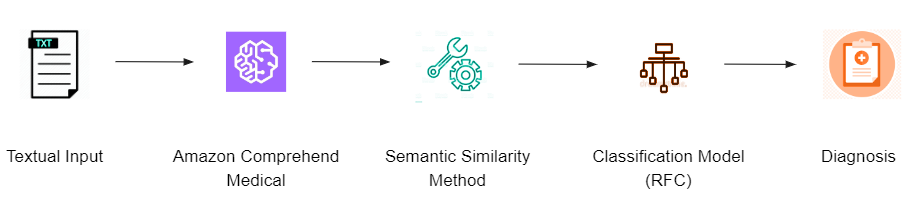

## **Overview**

In [57]:
data = pd.read_csv("/home/ec2-user/SageMaker/Data/Training.csv")

In [58]:
data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,diarrhoea,mild_fever,yellow_urine,yellowing_of_eyes,acute_liver_failure,fluid_overload,swelling_of_stomach,swelled_lymph_nodes,malaise,blurred_and_distorted_vision,phlegm,throat_irritation,redness_of_eyes,sinus_pressure,runny_nose,congestion,chest_pain,weakness_in_limbs,fast_heart_rate,pain_during_bowel_movements,pain_in_anal_region,bloody_stool,irritation_in_anus,neck_pain,dizziness,cramps,bruising,obesity,swollen_legs,swollen_blood_vessels,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,excessive_hunger,extra_marital_contacts,drying_and_tingling_lips,slurred_speech,knee_pain,hip_joint_pain,muscle_weakness,stiff_neck,swelling_joints,movement_stiffness,spinning_movements,loss_of_balance,unsteadiness,weakness_of_one_body_side,loss_of_smell,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,passage_of_gases,internal_itching,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [59]:
for old_name in data.columns:
    new_name = ' '.join(old_name.split('_'))
    data = data.rename(columns = {old_name:new_name})

In [60]:
columns_to_be_removed = ["Unnamed: 133", "inflammatory nails", "fluid overload", "fluid overload.1", "coma", "family history", "polyuria", "toxic look (typhos)", "malaise", "acute liver failure"]
data = data.drop(columns_to_be_removed,axis=1)

## **Textual Input**

In [86]:
texts_list = ["i am suffering from continuous sneezing, itching and red spots",
"I have knee pain in my right leg for 2 weeks now it isn't relieved by rest",
"i am suffering from vomiting and diarrhea ",
"I have some weight loss recently with increased anxiety, fast heart rate, fatigue and irritability"]

In [88]:
text_test = ["i am suffering from continuous sneezing, itching and red spots"]

## **Comprehend Medical**

In [89]:
def detect_entities(text, features):
    text = text.lower()
    my_session = boto3.session.Session()
    my_region = my_session.region_name
    client = boto3.client(service_name='comprehendmedical', region_name=my_region)
    entities = client.detect_entities(Text= text)['Entities']

    att = []
    keywords_per_sent = []
    
    for entity in entities:
        if 'Attributes' in entity:
            if entity.get('Attributes')[0].get('RelationshipScore') > 0.65:
                att.append(entity.get('Attributes')[0].get('Text'))
                att.append(entity.get('Text'))
                keywords_per_sent.append(' '.join(att))
                att = []
        else:
            if entity.get('Text') in features:
                keywords_per_sent.append(entity.get('Text'))
    
    return keywords_per_sent

In [90]:
keywords_per_sent= detect_entities(text_test[0], data.columns)
keywords_per_sent

['continuous sneezing', 'itching']

## **Semantic Similarity Method**

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

nlp = spacy.load("en_core_web_lg")

def nlp_similarity(X,Y):
    doc1 = nlp(X)
    doc2 = nlp(Y)
    return doc1.similarity(doc2)

def tfidf_similarity(X,Y):
    corpus = [X,Y]
    vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
    tfidf = vect.fit_transform(corpus)                                                                                                                                                                                                                       
    pairwise_similarity = tfidf * tfidf.T
    return pairwise_similarity

In [92]:
best_column_list=[]
for keyword in keywords_per_sent:
    max_similarity = 0
    best_column = ''
    for column in data.columns:
        similarity = nlp_similarity(keyword, column)
        if similarity >= 0.65 and similarity > max_similarity:
            max_similarity = similarity
            best_column = column
    if best_column != '':
        print(best_column)
        best_column_list.append(best_column)

continuous sneezing
itching


In [93]:
best_column_list

['continuous sneezing', 'itching']

## **Load Random Forrest Classifier**

In [94]:
RFC_Loaded_model = pickle.load(open('model_rfc.pkl', 'rb'))

In [95]:
featuresList= data.columns.drop(['prognosis']).tolist()

In [96]:
idx=[]
for best_column in best_column_list:
    inx= featuresList.index(best_column)
    idx.append(inx)

In [97]:
idx

[3, 0]

In [98]:
testArray= len(featuresList)*[0]

In [99]:
for i in idx:
    testArray[i]=1

In [100]:
print('*********')
print('Patient Complaint')
print('******************')
print(texts_list[0],'\n')
print('ML Model Diagnosis')
print('******************')
print(RFC_Loaded_model.predict(np.array(testArray).reshape(1,-1)),'\n')
print('#'*100)

*********
Patient Complaint
******************
i am suffering from continuous sneezing, itching and red spots 

ML Model Diagnosis
******************
['Allergy'] 

####################################################################################################


## **Diagnose**

In [75]:
def Diagnose(texts_list,features):
    
    df = pd.DataFrame(columns=features)
    my_session = boto3.session.Session()
    my_region = my_session.region_name
    client = boto3.client(service_name='comprehendmedical', region_name=my_region)
    for text in texts_list:
        text = ' '.join(text.split('_'))
        keywords_per_sent = detect_entities(text, features)
        df.loc[len(df)] = 0
        
        for keyword in keywords_per_sent:
            max_similarity = 0
            best_column = ''
            for column in df.columns:
                similarity = nlp_similarity(keyword, column)
                if similarity >= 0.65 and similarity > max_similarity:
                    max_similarity = similarity
                    best_column = column
            if best_column != '':
                df.loc[len(df)-1, best_column] = 1
                
    for i in range(len(texts_list)):
        print('\nCase {}'.format(i+1))
        print('*********')
        print('Patient Complaint')
        print('******************')
        print(texts_list[i],'\n')
        print('ML Model Diagnosis')
        print('******************')
        if df.iloc[i].sum() < 1:
            print("Can't be decided\n")
            print('#'*100)
        else:
            print(RFC_Loaded_model.predict(df)[i],'\n')
            print('#'*100)

In [87]:
Diagnose(texts_list,featuresList)


Case 1
*********
Patient Complaint
******************
i am suffering from continuous sneezing, itching and red spots 

ML Model Diagnosis
******************
Allergy 

####################################################################################################

Case 2
*********
Patient Complaint
******************
I have knee pain in my right leg for 2 weeks now it isn't relieved by rest 

ML Model Diagnosis
******************
Osteoarthristis 

####################################################################################################

Case 3
*********
Patient Complaint
******************
i am suffering from vomiting and diarrhea  

ML Model Diagnosis
******************
Gastroenteritis 

####################################################################################################

Case 4
*********
Patient Complaint
******************
I have some weight loss recently with increased anxiety, fast heart rate, fatigue and irritability 

ML Model Diagnosis
**********